# Creating Risk of Bias Inference Dataset
-------


## Importing libraries

In [1]:
import os
import ast
import pandas as pd
import numpy as np
import json
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import IterativeStratification
import matplotlib.pyplot as plt

In [2]:
from transformers import RobertaTokenizer, RobertaModel

## Constants

In [3]:
DATASET_PATH = os.path.join('D:\\', 'biomedical-datasets', 'cdsr_dataset')
CDSR_ROB_PATH = os.path.join(DATASET_PATH, 'rm5_risk_of_bias.csv')
CDSR_REF_PATH = os.path.join(DATASET_PATH, 'rm5-references.csv')

In [4]:
assert os.path.isfile(CDSR_ROB_PATH), "Arquivo rm5_risk_of_bias.csv não encontrado"
assert os.path.isfile(CDSR_REF_PATH), "Arquivo rm5-references.csv não encontrado"

In [5]:
cdsr_rob_df = pd.read_csv(CDSR_ROB_PATH)
cdsr_ref_df = pd.read_csv(CDSR_REF_PATH)

## Statistics by judgment of bias

In [6]:
len(cdsr_rob_df.id.unique())

32

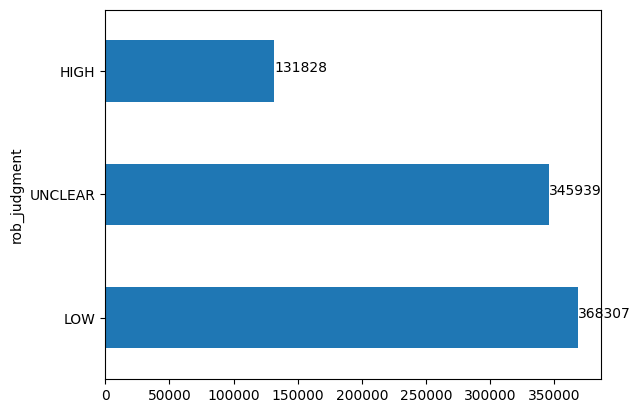

In [7]:
# plot barh for rob_judgment group by rob_judgment show values in the bar
rob_judgment = cdsr_rob_df['rob_judgment'].value_counts()
rob_judgment.plot.barh()
for index, value in enumerate(rob_judgment):
    plt.text(value, index, str(value))
plt.show()

## Counting tokens

Counting tokens to remove samples with more than 512 tokens. 

In [14]:
tokenizer = RobertaTokenizer.from_pretrained('allenai/biomed_roberta_base')

In [62]:
def count_tokens(text, max_length=512):
    if pd.notnull(text) or pd.notna(text):
        return len(tokenizer.encode(text, truncation=True, max_length=max_length))
    else:
        return 0
    
def count_hypothesis_tokens(row, max_length=512):
    if pd.notnull(row.description) or pd.notna(row.description):
        return len(tokenizer.encode(row.description, truncation=True, max_length=max_length))
    elif pd.notnull(row.group_description) or pd.notna(row.group_description):
        return len(tokenizer.encode(row.group_description, truncation=True, max_length=max_length))
    elif pd.notna(row['name']) or pd.notnull(row['name']):
        return len(tokenizer.encode(row['name'], truncation=True, max_length=max_length))
    else:
        return 0
    
def get_hypothesis(row):
    if pd.notnull(row.description) or pd.notna(row.description):
        return row.description
    elif pd.notnull(row.group_description) or pd.notna(row.group_description):
        return row.group_description
    elif pd.notna(row['name']) or pd.notnull(row['name']):
        return row['name']
    else:
        return ''

In [63]:
cdsr_rob_df['num_h_tokens'] = cdsr_rob_df.apply(lambda x: count_hypothesis_tokens(x), axis=1)
cdsr_rob_df['hypothesis'] = cdsr_rob_df.apply(lambda x: get_hypothesis(x), axis=1)
cdsr_rob_df['num_p_tokens'] = cdsr_rob_df.apply(lambda x: count_tokens(x.support_judgment_str), axis=1)
cdsr_rob_df['num_tokens'] = cdsr_rob_df['num_h_tokens'] + cdsr_rob_df['num_p_tokens']

In [66]:
cdsr_rob_df

,review,id,name,description,core_item,level,no,study_id,study_name,group_id,group_description,rob_judgment,support_judgment,support_judgment_str,num_p_tokens,num_h_tokens,num_tokens,hypothesis
0,D:\biomedical-datasets\cdsr_dataset\rm5\CD0000...,QIT-02,Allocation concealment (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,2,STD-Blecher-1967,Blecher 1967,NaN,NaN,HIGH,Inadequate,Inadequate,5,21,26,Selection bias (biased allocation to intervent...
1,D:\biomedical-datasets\cdsr_dataset\rm5\CD0000...,QIT-02,Allocation concealment (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,2,STD-MacRae-1971,MacRae 1971,NaN,NaN,HIGH,Inadequate,Inadequate,5,21,26,Selection bias (biased allocation to intervent...
2,D:\biomedical-datasets\cdsr_dataset\rm5\CD0000...,QIT-02,Allocation concealment (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,2,STD-Varma-1973,Varma 1973,NaN,NaN,HIGH,Inadequate,Inadequate,5,21,26,Selection bias (biased allocation to intervent...
3,D:\biomedical-datasets\cdsr_dataset\rm5\CD0000...,QIT-01,Adequate sequence generation?,Was the allocation sequence adequately generated?,True,STUDY,1,STD-Banninger-1978,Banninger 1978,NaN,NaN,HIGH,"{'BR': None, '#text': ""Allocated by 'alternati...",Allocated by 'alternating sequence'.,10,9,19,Was the allocation sequence adequately generated?
4,D:\biomedical-datasets\cdsr_dataset\rm5\CD0000...,QIT-01,Adequate sequence generation?,Was the allocation sequence adequately generated?,True,STUDY,1,STD-Beard-1974,Beard 1974,NaN,NaN,UNCLEAR,"{'BR': None, '#text': 'Allocated ""randomly to ...","Allocated ""randomly to two groups"" - method no...",16,9,25,Was the allocation sequence adequately generated?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846069,D:\biomedical-datasets\cdsr_dataset\rm5\CD0154...,QIT-07,Other bias,Bias due to problems not covered elsewhere in ...,True,STUDY,7,STD-Walsh-2020,Walsh 2020,NaN,NaN,UNCLEAR,[],NaN,0,13,13,Bias due to problems not covered elsewhere in ...
846070,D:\biomedical-datasets\cdsr_dataset\rm5\CD0154...,QIT-07,Other bias,Bias due to problems not covered elsewhere in ...,True,STUDY,7,STD-Wu-2021a,Wu 2021a,NaN,NaN,UNCLEAR,[],NaN,0,13,13,Bias due to problems not covered elsewhere in ...
846071,D:\biomedical-datasets\cdsr_dataset\rm5\CD0154...,QIT-07,Other bias,Bias due to problems not covered elsewhere in ...,True,STUDY,7,STD-Xia-2020,Xia 2020,NaN,NaN,UNCLEAR,[],NaN,0,13,13,Bias due to problems not covered elsewhere in ...
846072,D:\biomedical-datasets\cdsr_dataset\rm5\CD0154...,QIT-07,Other bias,Bias due to problems not covered elsewhere in ...,True,STUDY,7,STD-Xia-2021,Xia 2021,NaN,NaN,UNCLEAR,[],NaN,0,13,13,Bias due to problems not covered elsewhere in ...


In [70]:
cdsr_rob_512_df = cdsr_rob_df[cdsr_rob_df['num_tokens'] <= 512]
cdsr_rob_128_df = cdsr_rob_df[cdsr_rob_df['num_tokens'] <= 128]

## Splitting dataset

In [71]:
def iterative_split(df, test_size, stratify_columns):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'

    From https://madewithml.com/courses/mlops/splitting/#stratified-split
    """
    # One-hot encode the stratify columns and concatenate them
    one_hot_cols = [pd.get_dummies(df[col]) for col in stratify_columns]
    one_hot_cols = pd.concat(one_hot_cols, axis=1).to_numpy()
    stratifier = IterativeStratification(
        n_splits=2, order=len(stratify_columns), sample_distribution_per_fold=[test_size, 1-test_size])
    train_indices, test_indices = next(stratifier.split(df.to_numpy(), one_hot_cols))
    # Return the train and test set dataframes
    train, test = df.iloc[train_indices], df.iloc[test_indices]
    return train, test

In [73]:
train_512, val_test_512 = iterative_split(cdsr_rob_512_df, 0.4, ['rob_judgment'])
val_512, test_512 = iterative_split(val_test_512, 0.5, ['rob_judgment'])

train_128, val_test_128 = iterative_split(cdsr_rob_128_df, 0.4, ['rob_judgment'])
val_128, test_128 = iterative_split(val_test_128, 0.5, ['rob_judgment'])

In [74]:
train_512.to_csv(os.path.join(DATASET_PATH, 'rob_train_512.csv'), index=False)
val_512.to_csv(os.path.join(DATASET_PATH, 'rob_val_512.csv'), index=False)
test_512.to_csv(os.path.join(DATASET_PATH, 'rob_test_512.csv'), index=False)

train_128.to_csv(os.path.join(DATASET_PATH, 'rob_train_128.csv'), index=False)
val_128.to_csv(os.path.join(DATASET_PATH, 'rob_val_128.csv'), index=False)
test_128.to_csv(os.path.join(DATASET_PATH, 'rob_test_128.csv'), index=False)

## Downsampling dataset

In [75]:
grouped_df = train_512.groupby('rob_judgment')
min_samples = grouped_df.size().min()
downsampled_512_df = grouped_df.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

grouped_df = train_128.groupby('rob_judgment')
min_samples = grouped_df.size().min()
downsampled_128_df = grouped_df.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

In [84]:
downsampled_512_df.to_csv(os.path.join(DATASET_PATH, 'rob_downsampled_train_512.csv'), index=False)
downsampled_128_df.to_csv(os.path.join(DATASET_PATH, 'rob_downsampled_train_128.csv'), index=False)

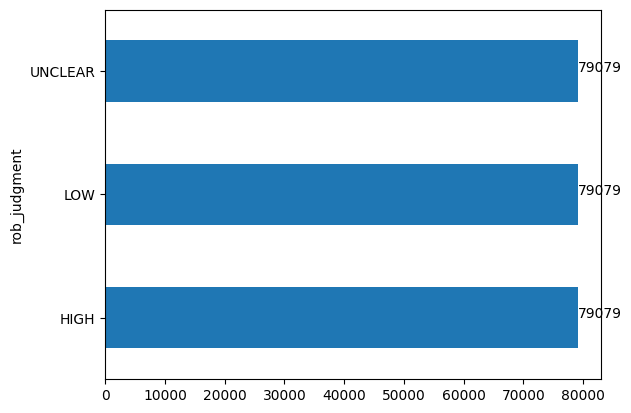

In [76]:
rob_judgment = downsampled_512_df['rob_judgment'].value_counts()
rob_judgment.plot.barh()
for index, value in enumerate(rob_judgment):
    plt.text(value, index, str(value))
plt.show()

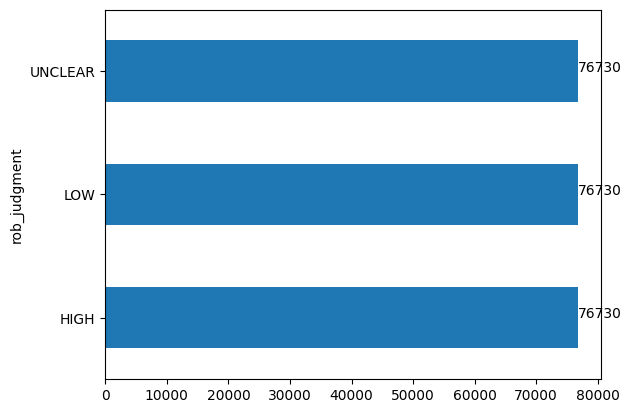

In [77]:
rob_judgment = downsampled_128_df['rob_judgment'].value_counts()
rob_judgment.plot.barh()
for index, value in enumerate(rob_judgment):
    plt.text(value, index, str(value))
plt.show()

In [78]:
train_512.shape, val_512.shape, test_512.shape

((507606, 18), (169202, 18), (169202, 18))

In [79]:
train_128.shape, val_128.shape, test_128.shape

((499628, 18), (166542, 18), (166543, 18))

In [85]:
downsampled_128_df.shape, downsampled_512_df.shape

((230190, 18), (237237, 18))

In [86]:
downsampled_128_df.rob_judgment.value_counts(), downsampled_512_df.rob_judgment.value_counts()

(rob_judgment
 HIGH       76730
 LOW        76730
 UNCLEAR    76730
 Name: count, dtype: int64,
 rob_judgment
 HIGH       79079
 LOW        79079
 UNCLEAR    79079
 Name: count, dtype: int64)

In [83]:
train_512.rob_judgment.value_counts(), val_512.rob_judgment.value_counts(), test_512.rob_judgment.value_counts()

(rob_judgment
 LOW        220973
 UNCLEAR    207554
 HIGH        79079
 Name: count, dtype: int64,
 rob_judgment
 LOW        73658
 UNCLEAR    69184
 HIGH       26360
 Name: count, dtype: int64,
 rob_judgment
 LOW        73658
 UNCLEAR    69185
 HIGH       26359
 Name: count, dtype: int64)

In [81]:
train_128.rob_judgment.value_counts(), val_128.rob_judgment.value_counts(), test_128.rob_judgment.value_counts()

(rob_judgment
 LOW        217384
 UNCLEAR    205514
 HIGH        76730
 Name: count, dtype: int64,
 rob_judgment
 LOW        72461
 UNCLEAR    68505
 HIGH       25576
 Name: count, dtype: int64,
 rob_judgment
 LOW        72461
 UNCLEAR    68505
 HIGH       25577
 Name: count, dtype: int64)

In [82]:
train_512.sample(100)

,review,id,name,description,core_item,level,no,study_id,study_name,group_id,group_description,rob_judgment,support_judgment,support_judgment_str,num_p_tokens,num_h_tokens,num_tokens,hypothesis
516297,D:\biomedical-datasets\cdsr_dataset\rm5\CD0094...,QIT-05,Selective reporting (reporting bias),Reporting bias due to selective outcome reporting,True,STUDY,5,STD-Mishra-2010a,Mishra 2010a,NaN,NaN,UNCLEAR,No protocol found,No protocol found,5,9,14,Reporting bias due to selective outcome reporting
808695,D:\biomedical-datasets\cdsr_dataset\rm5\CD0136...,QIT-14,Bias in selection of the reported result,Selective reporting of results in a way that d...,False,STUDY,14,STD-Losken-2009,Losken 2009,NaN,NaN,UNCLEAR,[],NaN,0,32,32,Selective reporting of results in a way that d...
123719,D:\biomedical-datasets\cdsr_dataset\rm5\CD0029...,QIT-02,Bias due to deviations from intended intervent...,NaN,True,GROUP,2,STD-Walters-2013,Walters 2013,QIG-02.04,Mortality: all-cause mortality (primary analysis),HIGH,"[{'B': {'I': 'Effect of assignment:'}, 'BR': N...","-""The limitations of the study were the high r...",67,13,80,Mortality: all-cause mortality (primary analysis)
90355,D:\biomedical-datasets\cdsr_dataset\rm5\CD0020...,QIT-02,Allocation concealment?,Was allocation adequately concealed?,True,STUDY,2,STD-Lao-2001,Lao 2001,NaN,NaN,LOW,A-adequate,A-adequate,6,7,13,Was allocation adequately concealed?
112440,D:\biomedical-datasets\cdsr_dataset\rm5\CD0028...,QIT-16,Comparable arms,NaN,False,STUDY,16,STD-Sigurgeirsson-2009,Sigurgeirsson 2009,NaN,NaN,UNCLEAR,Same time and attention given to participants ...,Same time and attention given to participants ...,12,5,17,Comparable arms
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772388,D:\biomedical-datasets\cdsr_dataset\rm5\CD0132...,QIT-05,Incomplete outcome data (attrition bias),"Attrition bias due to amount, nature or handli...",True,GROUP,5,STD-Adler-2015,Adler 2015,QIG-05.01,All outcomes,LOW,"Although there was some attrition, this was re...","Although there was some attrition, this was re...",34,16,50,"Attrition bias due to amount, nature or handli..."
70546,D:\biomedical-datasets\cdsr_dataset\rm5\CD0017...,QIT-01,Random sequence generation (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,1,STD-Cornu-2012,Cornu 2012,NaN,NaN,LOW,Computerised randomisation was centralised by ...,Computerised randomisation was centralised by ...,15,20,35,Selection bias (biased allocation to intervent...
382685,D:\biomedical-datasets\cdsr_dataset\rm5\CD0071...,QIT-01,Random sequence generation (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,1,STD-Swanson-1998,Swanson 1998,NaN,NaN,LOW,"""computer-generated randomisation list""",computer-generated randomisation list,8,20,28,Selection bias (biased allocation to intervent...
656357,D:\biomedical-datasets\cdsr_dataset\rm5\CD0116...,QIT-01,Random sequence generation (selection bias),Selection bias (biased allocation to intervent...,True,STUDY,1,STD-Lamont-2001,Lamont 2001,NaN,NaN,UNCLEAR,Sequence generation was not reported.,Sequence generation was not reported.,9,20,29,Selection bias (biased allocation to intervent...


In [89]:
downsampled_512_df.sample(100)[['name', 'support_judgment_str', 'rob_judgment']]

,name,support_judgment_str,rob_judgment
44884,Bias due to deviations from intended intervent...,"The study was not blinded, and 7% of participa...",HIGH
214783,Random sequence generation (selection bias),No details reported.,UNCLEAR
137449,Random sequence generation (selection bias),Randomisation was done by computer,LOW
202934,Selective reporting (reporting bias),All outcomes in trial reported; no protocol av...,UNCLEAR
124685,Selective reporting (reporting bias),all outcomes reported,LOW
...,...,...,...
189595,Incomplete outcome data (attrition bias),This study did not reported adverse events. No...,UNCLEAR
3728,Blinding?,NaN,HIGH
119640,Selective reporting (reporting bias),Comment: study authors mentioned explicitly th...,LOW
19218,Group similarity at baseline,"Slight imbalance in numbers, place of treatmen...",HIGH
